In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion() # interactive mode

In [3]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [4]:
landmarks_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Columns: 137 entries, image_name to part_67_y
dtypes: int64(136), object(1)
memory usage: 73.9+ KB


In [5]:
n = 65
img_name= landmarks_frame.iloc[n,0]
landmarks = landmarks_frame.iloc[n,1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1,2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


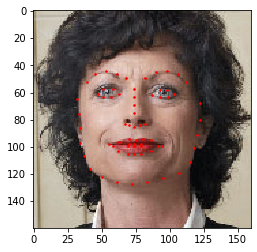

In [6]:
def show_landmarks(image, landmarks):
    """Show image with Landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:,0],landmarks[:,1], s=10, marker='.', c='r')
    plt.pause(0.001)
    
plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
              landmarks)
plt.show()

## Dataset class

In [7]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx): ## dataset[i] 를 위한 메소드
        img_name = os.path.join(self.root_dir,
                               self.landmarks_frame.iloc[idx,0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {'image':image, 'landmarks':landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

0 (324, 215, 3) (68, 2)


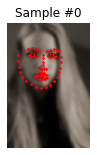

1 (500, 333, 3) (68, 2)


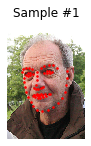

2 (250, 258, 3) (68, 2)


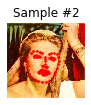

3 (434, 290, 3) (68, 2)


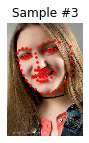

In [9]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                   root_dir='data/faces/')
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    # show_landmarks(sample['image'],sample['landmarks'])  와 동일
    
    if i==3 :
        plt.show()
        break

In [10]:
sample = face_dataset[0]
sample

{'image': Array([[[ 66,  59,  53],
         [ 66,  59,  53],
         [ 66,  59,  53],
         ...,
         [ 59,  54,  48],
         [ 59,  54,  48],
         [ 59,  54,  48]],
 
        [[ 67,  60,  54],
         [ 67,  60,  54],
         [ 67,  60,  54],
         ...,
         [ 59,  54,  48],
         [ 59,  54,  48],
         [ 59,  54,  48]],
 
        [[ 67,  60,  54],
         [ 67,  60,  54],
         [ 67,  60,  54],
         ...,
         [ 59,  54,  48],
         [ 59,  54,  48],
         [ 59,  54,  48]],
 
        ...,
 
        [[ 16,  15,  13],
         [ 18,  17,  15],
         [ 21,  17,  14],
         ...,
         [155, 143, 131],
         [157, 145, 133],
         [157, 145, 133]],
 
        [[ 14,  13,  11],
         [ 17,  16,  14],
         [ 20,  16,  13],
         ...,
         [154, 142, 130],
         [158, 146, 134],
         [158, 146, 134]],
 
        [[ 13,  12,  10],
         [ 16,  15,  13],
         [ 20,  16,  13],
         ...,
         [153, 141,

## Transforms

transform은 function보단 class로 만들어서 매번 parameter 입력하는 걸 방지하도록 함

In [11]:
class Rescale(object):
    """Rescale the image in a sample to a give size.
    
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # assert 는 뒤가 참인지 판정, isinstance는 속성 검사
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h /w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w /h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively.
        landmarks = landmarks * [new_w / w ,new_h/h] # landmarks 는 float 타입
        
        return {'image':img, 'landmarks':landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.
    
    Args:
        output_size (tuple or int): Desired output size. If int, square crop is made.    
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) ==2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w-new_w)
        
        image = image[top:top+new_h, left:left+new_w]
        landmarks = landmarks - [left,top]
        
        return {'image': image, 'landmarks': landmarks}
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because
        # numpy image : H x W x C
        # torch image : C x H x W
        image = image.transpose((2,0,1))
        return {'image':torch.from_numpy(image),
               'landmarks':torch.from_numpy(landmarks)}

## Compose transforms

짧은 축을 256 으로 만든 후 224 정방형 사이즈로 크롭하고 싶다.

In [12]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

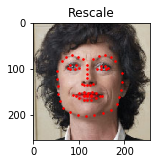

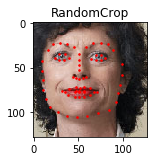

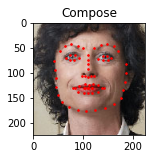

In [13]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i , tsfrm in enumerate([scale,crop,composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1,3,i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

## Iterating through the dataset

In [14]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                          root_dir='data/faces/',
                                          transform=transforms.Compose([Rescale(256),
                                                                       RandomCrop(224),
                                                                       ToTensor()
                                                                       ]))

In [15]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['landmarks'].size())
    
    if i==3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


그러나 for문을 쓰면 batch, shuffle, 병렬 작업 불가하므로,
이를 개선하기 위해 torch.utils.data.DataLoader 를 사용하자

In [24]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=2)

In [25]:
a=torch.tensor([[1,2,3],[4,5,6]])
a.size(), a.size(0)

(torch.Size([2, 3]), 2)

In [26]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with lanmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i+1) * grid_border_size,
                   landmarks_batch[i, :, 1].numpy() + grid_border_size, s=10, marker='.', c='r')
        plt.title('Batch from dataloader')

In [27]:

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
         sample_batched['landmarks'].size())
    
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

BrokenPipeError: [Errno 32] Broken pipe

## Afterword: torchvision

In [29]:
from torchvision import datasets

data_transform = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229,0.224,0.225])
])

hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                            batch_size=4, shuffle=True,
                                            num_worker=4)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'hymenoptera_data/train'